<div class="alert alert-block alert-info">
<h1> Analyse Agilent peak table </h1>
</div>

- [0 - Import modules](#0---Import-modules)
- [0 - Import data](#0---Import-data)
- [1 - Preprocess data](#1---Preprocess-data)
  - [a - Split peak table between metadata and peak intensities](#a---Split-peak-table-between-metadata-and-peak-intensities)
  - [b - Drop metadata columns with more than N% of missing values over the samples](#b---Drop-metadata-columns-with-more-than-N%-of-missing-values-over-the-samples)
  - [c - Keep only quantitative metadata and remove Blanks rows](#c---Keep-only-quantitative-metadata-and-remove-Blanks-rows)
  - [d - Check missing values in intensities](#d---Check-missing-values-in-intensities)
- [2 - Impute missing values](#2---Impute-missing-values)
  - [a - Impute intensities with 1's](#a---Impute-intensities-with-1's)
  - [b - Convert all intensities columns to integers](#b---Convert-all-intensities-columns-to-integers)
  - [c - Impute quantitative metadata with half min value of column](#c---Impute-quantitative-metadata-with-half-min-value-of-column)
- [3 - Concat preprocessed metadata (*metadata2_no_Blanks_quanti_imp_halfmin*) and preprocessed intensities (*intensities_imp1*)](#3---Concat-preprocessed-metadata-(*metadata2_no_Blanks_quanti_imp_halfmin*)-and-preprocessed-intensities-(*intensities_imp1*))
- [4 - Standard scale imputed peak table (metadata + intensities)](#4---Standard-scale-imputed-peak-table-(metadata-+-intensities))
- [5 - Dimensionality reduction](#5---Dimensionality-reduction)
  - [a - PCA then t-SNE](#a---PCA-then-t-SNE)
- [6 - Clustering](#6---Clustering)
  - [a - Kmeans](#a---Kmeans)
  - [b - Affinity propagation](#b---Affinity-propagation)
  - [c - Hierarchical clustering](#c---Hierarchical-clustering)

# 0 - Import modules

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import re
pwd = ! pwd
pwd = re.sub('notebooks/analyse_Agilent', '', pwd[0])
print(f'Working directory : {pwd}')

Working directory : /home/jovyan/work/


In [3]:
# Tune the visual settings for figures in seaborn
sns.set_context(
    "notebook", font_scale=1.2, rc={"figure.figsize": (15,10), "axes.titlesize": 15}
)

from matplotlib import rcParams

rcParams["figure.figsize"] = 15, 10

sns.set_theme(style="darkgrid")

In [4]:
import sys
sys.path.append(pwd + 'bin/')

# 0 - Import data

In [5]:
peakTable_Agilent = pd.read_csv(pwd + 'data/prepare_HCC_data/usable_peakTables/peakTable-Agilent-186_samples-useful_metadata.csv',
                                sep=',', decimal='.', na_values='NA')
print(peakTable_Agilent.shape)
peakTable_Agilent.head()

(189, 1358)


,SampleID_full,SampleID,Id_Bma,Idepic,Idepic_Bio,Idepic_Samp,Id Aliquot,CaseCtrl,Typ_Tumo,Match_Caseset,...,225.1218@0.86389714,398.7578@8.768545,288.1272@6.883725,126.0287@1.5353005,429.2873@6.211831,419.2505@8.916426,518.2205@6.2066946,400.2586@7.130359,103.0998@7.112515,267.142@6.969883
0,EPIC_Liver_Cancer_NR160614_001_Blank_001,Blank_001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,EPIC_Liver_Cancer_NR160614_101_Blank_101,Blank_101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1429.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,EPIC_Liver_Cancer_NR160614_201_Blank_201,Blank_201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1685.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,EPIC_Liver_Cancer_NR160614_007_41-LivCan_153_007,LivCan_153,41-LivCan_153,41____41041872,41____41041872,41041872-s2#C1,41041872-s2#C,Incident,HCC/,82.0,...,NaN,98959.0,20987.0,178906.0,NaN,184072.0,2547.0,6454.0,NaN,149023.0
4,EPIC_Liver_Cancer_NR160614_008_41-LivCan_154_008,LivCan_154,41-LivCan_154,41____41046868,41____41046868,41046868-s2#C1,41046868-s2#C,Non-case,NaN,82.0,...,2414.0,93145.0,28323.0,NaN,NaN,NaN,1043.0,6390.0,403011.0,164386.0


# 1 - Preprocess data

## a - Split peak table between metadata and peak intensities

### Last metadata column is *Wcrf_Pf_Cal* (as we created the file in the notebook *08-keep_relevant_metadata.ipynb*)

In [6]:
metadata = peakTable_Agilent.loc[:, :'Wcrf_Pf_Cal']
metadata['Typ_Tumo'] = metadata['Typ_Tumo'].str.replace('/', '')
metadata['Typ_Tumo'] = metadata.loc[3:, 'Typ_Tumo'].fillna('Non-case')
metadata.loc[:2, 'CaseCtrl'] = 'Blank'
metadata

,SampleID_full,SampleID,Id_Bma,Idepic,Idepic_Bio,Idepic_Samp,Id Aliquot,CaseCtrl,Typ_Tumo,Match_Caseset,...,Wcrf_Ed,Wcrf_Fv,Wcrf_Fv_Cal,Wcrf_Fwg,Wcrf_Fwg_Cal,Wcrf_Meat,Wcrf_Meat_Cal,Wcrf_Pa,Wcrf_Pf,Wcrf_Pf_Cal
0,EPIC_Liver_Cancer_NR160614_001_Blank_001,Blank_001,NaN,NaN,NaN,NaN,NaN,Blank,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,EPIC_Liver_Cancer_NR160614_101_Blank_101,Blank_101,NaN,NaN,NaN,NaN,NaN,Blank,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,EPIC_Liver_Cancer_NR160614_201_Blank_201,Blank_201,NaN,NaN,NaN,NaN,NaN,Blank,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,EPIC_Liver_Cancer_NR160614_007_41-LivCan_153_007,LivCan_153,41-LivCan_153,41____41041872,41____41041872,41041872-s2#C1,41041872-s2#C,Incident,HCC,82.0,...,0.5,1.0,0.5,0.50,0.50,0.0,0.0,0.0,1.00,0.75
4,EPIC_Liver_Cancer_NR160614_008_41-LivCan_154_008,LivCan_154,41-LivCan_154,41____41046868,41____41046868,41046868-s2#C1,41046868-s2#C,Non-case,Non-case,82.0,...,0.5,0.5,0.0,0.50,0.50,0.5,0.5,0.0,0.50,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,EPIC_Liver_Cancer_NR160614_275_32-LivCan_080_275,LivCan_080,275_32-LivCan_080_275,32____3208004E,32____32253231,32253231-s3#C1,32253231-s3#C,Non-case,Non-case,56.0,...,0.5,0.5,0.5,0.50,0.50,0.5,0.5,0.0,0.50,0.25
185,EPIC_Liver_Cancer_NR160614_281_22-LivCan_375_281,LivCan_375,281_22-LivCan_375_281,22____22281416,22____22281416,22281416-s1#B1,22281416-s1#B,Incident,HCC,383.0,...,0.5,1.0,1.0,0.75,0.75,0.0,0.0,0.0,1.00,1.00
186,EPIC_Liver_Cancer_NR160614_282_22-LivCan_376_282,LivCan_376,282_22-LivCan_376_282,22____22281701,22____22281701,22281701-s1#B1,22281701-s1#B,Non-case,Non-case,383.0,...,0.5,1.0,1.0,0.75,0.75,0.0,0.0,1.0,0.75,0.75
187,EPIC_Liver_Cancer_NR160614_283_71-LivCan_165_283,LivCan_165,283_71-LivCan_165_283,71____71000825,71____71000065,71000065-s2#C1,71000065-s2#C,Incident,HCC,147.0,...,0.0,0.0,0.5,0.00,0.00,0.0,0.0,0.0,0.25,0.50


In [7]:
intensities = peakTable_Agilent.drop(metadata.columns, axis=1)
intensities

,89.9697@0.5505152,90.973@0.55399996,939.813@0.56963736,157.9574@0.5643974,871.8258@0.5736113,803.8387@0.5745634,973.8083@0.56959826,599.8754@0.5742488,811.8258@0.57766384,667.8631@0.57489955,...,225.1218@0.86389714,398.7578@8.768545,288.1272@6.883725,126.0287@1.5353005,429.2873@6.211831,419.2505@8.916426,518.2205@6.2066946,400.2586@7.130359,103.0998@7.112515,267.142@6.969883
0,48008,418,NaN,16766,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,44590,223,NaN,14908,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1429.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,46261,333,NaN,14117,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1685.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4195138,40495,42242.0,2794282,50841.0,60628.0,74517.0,100523.0,64318.0,108194.0,...,NaN,98959.0,20987.0,178906.0,NaN,184072.0,2547.0,6454.0,NaN,149023.0
4,4306680,38555,49922.0,2930790,61613.0,73916.0,84277.0,120525.0,69334.0,133694.0,...,2414.0,93145.0,28323.0,NaN,NaN,NaN,1043.0,6390.0,403011.0,164386.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,4416705,40954,47502.0,3017039,56174.0,69562.0,81828.0,93578.0,64371.0,122940.0,...,NaN,97137.0,24680.0,96880.0,1965.0,NaN,1781.0,40682.0,228548.0,111077.0
185,4727455,44619,65454.0,3237331,80203.0,99917.0,114212.0,127797.0,59777.0,169132.0,...,4823.0,NaN,17378.0,93893.0,9988.0,87218.0,9131.0,NaN,221296.0,97565.0
186,4643850,44234,62270.0,3170819,75882.0,94129.0,104118.0,120689.0,60576.0,159518.0,...,4761.0,NaN,16624.0,108831.0,3127.0,NaN,2387.0,17483.0,369559.0,NaN
187,4107050,38737,27127.0,2681910,30093.0,39345.0,52179.0,57230.0,56211.0,67452.0,...,38674.0,89525.0,11619.0,105422.0,3152.0,89313.0,2485.0,14052.0,212520.0,NaN


In [84]:
intensities[intensities.columns[~intensities.columns.str.contains('@')]]

,N-Methylnicotinamide,Epinephrine,creatinine,guanidoacetate,L-Alanine,glutamine,4-Oxoproline (HMDB0304793),Citrulline,3-Aminoisobutyric acid,5-Aminopentanoic acid,...,L-Homoserine,N1-Acetylspermidine,4-Pyridoxic acid,N-Acetylglycine,L-Rhamnulose,Dimethylsulfone,Sphingosine,Proline betaine +2.3243585,homocysteine,Sinapic acid
0,NaN,NaN,1739,NaN,10791,75797,18656.0,1919,NaN,65648.0,...,31462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2839,NaN,5212,27907,9610.0,619,NaN,802492.0,...,12490,NaN,588.0,NaN,5295.0,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,2998,NaN,4296,13156,3828.0,635,NaN,1562434.0,...,5730,268.0,457.0,NaN,7806.0,NaN,NaN,NaN,NaN,NaN
3,16317.0,619389.0,9954784,33626.0,2012405,2677295,697127.0,218078,211265.0,9757283.0,...,670461,15899.0,10884.0,3238.0,12173.0,30351.0,4539.0,13775.0,6492.0,3810.0
4,6821.0,487724.0,7650518,37680.0,2142388,2910535,729157.0,118980,444865.0,12702719.0,...,1133997,14470.0,5579.0,3929.0,6931.0,23718.0,NaN,12220.0,5767.0,5723.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,19846.0,700091.0,6583229,32422.0,1661337,2065337,553258.0,101618,227041.0,9270083.0,...,725281,14545.0,5908.0,1449.0,12866.0,16324.0,14554.0,10985.0,6011.0,10575.0
185,91603.0,870683.0,4511929,26181.0,1729412,2194687,582026.0,153977,299443.0,7411834.0,...,907552,27392.0,6259.0,6054.0,24382.0,16949.0,19208.0,14401.0,11661.0,4582.0
186,45385.0,685327.0,5477736,36539.0,2413415,2569445,674639.0,129895,159141.0,6928192.0,...,575087,18239.0,4284.0,12353.0,24981.0,26709.0,6737.0,9072.0,12114.0,6776.0
187,57053.0,793778.0,5547938,33981.0,1472494,2894056,752951.0,128780,290696.0,12484099.0,...,757089,20838.0,3681.0,9994.0,23876.0,20883.0,18881.0,18456.0,13635.0,11975.0


## b - Drop metadata columns with more than N% of missing values over the samples

(189, 143)


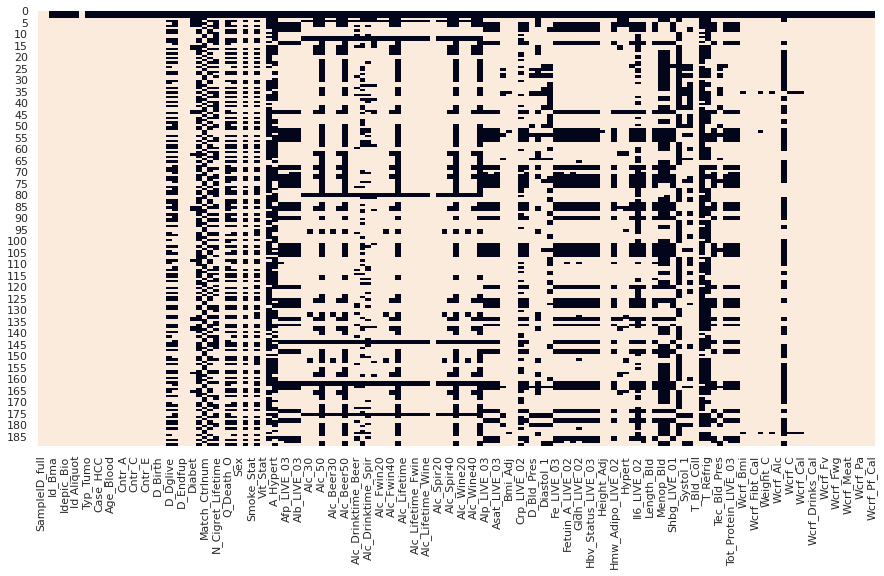

In [8]:
plt.figure(figsize=(15,8))
print(metadata.shape)
sns.heatmap(metadata.notna(), cbar=False);

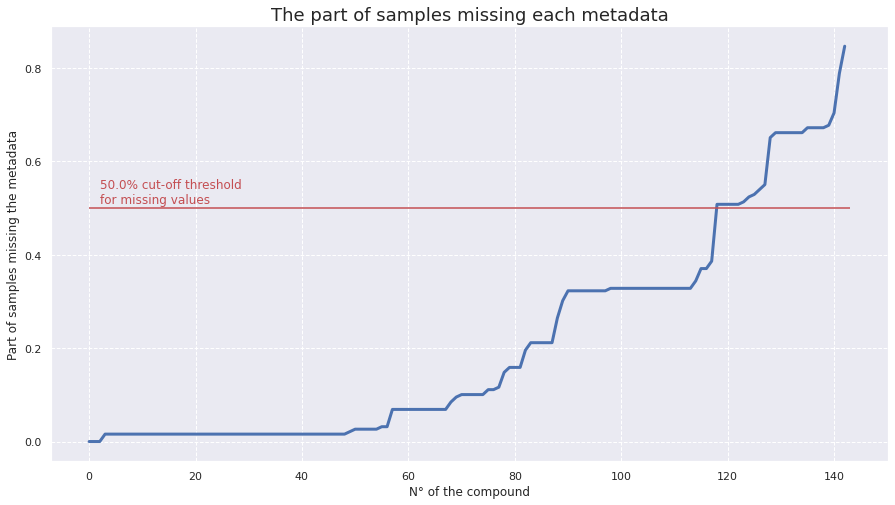

In [9]:
perc_mv = metadata.isna().sum() / metadata.shape[0]
threshold = 0.5
plt.figure(figsize=(15,8))
plt.plot(perc_mv.sort_values().values, color='b', linewidth=3)
plt.hlines(y=threshold, xmin=0, xmax=len(perc_mv), color ='r')
plt.text(x=2, y=threshold+0.01, s=f'{threshold*100}% cut-off threshold \nfor missing values', color='r', fontsize=12)
plt.xlabel('N° of the compound', fontsize=12)
plt.ylabel('Part of samples missing the metadata', fontsize=12)
plt.title('The part of samples missing each metadata', fontsize=18)
plt.grid(linestyle='--', linewidth=1)
plt.show()

#### Set the desired threshold below which we remove the column

In [10]:
threshold = 0.5
rate_mv = metadata.isna().sum() / metadata.shape[0]
metadata2 = metadata[rate_mv[rate_mv < threshold].index]
print(f'We remove metadata columns with more than {threshold*100}% of missing values.\
\nFrom {metadata.shape[1]} columns initially, we have now {metadata2.shape[1]} columns \
({metadata.shape[1] - metadata2.shape[1]} removed).')
metadata2

We remove metadata columns with more than 50.0% of missing values.
From 143 columns initially, we have now 118 columns (25 removed).


,SampleID_full,SampleID,Id_Bma,Idepic,Idepic_Bio,Idepic_Samp,Id Aliquot,CaseCtrl,Typ_Tumo,Match_Caseset,...,Wcrf_Ed,Wcrf_Fv,Wcrf_Fv_Cal,Wcrf_Fwg,Wcrf_Fwg_Cal,Wcrf_Meat,Wcrf_Meat_Cal,Wcrf_Pa,Wcrf_Pf,Wcrf_Pf_Cal
0,EPIC_Liver_Cancer_NR160614_001_Blank_001,Blank_001,NaN,NaN,NaN,NaN,NaN,Blank,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,EPIC_Liver_Cancer_NR160614_101_Blank_101,Blank_101,NaN,NaN,NaN,NaN,NaN,Blank,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,EPIC_Liver_Cancer_NR160614_201_Blank_201,Blank_201,NaN,NaN,NaN,NaN,NaN,Blank,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,EPIC_Liver_Cancer_NR160614_007_41-LivCan_153_007,LivCan_153,41-LivCan_153,41____41041872,41____41041872,41041872-s2#C1,41041872-s2#C,Incident,HCC,82.0,...,0.5,1.0,0.5,0.50,0.50,0.0,0.0,0.0,1.00,0.75
4,EPIC_Liver_Cancer_NR160614_008_41-LivCan_154_008,LivCan_154,41-LivCan_154,41____41046868,41____41046868,41046868-s2#C1,41046868-s2#C,Non-case,Non-case,82.0,...,0.5,0.5,0.0,0.50,0.50,0.5,0.5,0.0,0.50,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,EPIC_Liver_Cancer_NR160614_275_32-LivCan_080_275,LivCan_080,275_32-LivCan_080_275,32____3208004E,32____32253231,32253231-s3#C1,32253231-s3#C,Non-case,Non-case,56.0,...,0.5,0.5,0.5,0.50,0.50,0.5,0.5,0.0,0.50,0.25
185,EPIC_Liver_Cancer_NR160614_281_22-LivCan_375_281,LivCan_375,281_22-LivCan_375_281,22____22281416,22____22281416,22281416-s1#B1,22281416-s1#B,Incident,HCC,383.0,...,0.5,1.0,1.0,0.75,0.75,0.0,0.0,0.0,1.00,1.00
186,EPIC_Liver_Cancer_NR160614_282_22-LivCan_376_282,LivCan_376,282_22-LivCan_376_282,22____22281701,22____22281701,22281701-s1#B1,22281701-s1#B,Non-case,Non-case,383.0,...,0.5,1.0,1.0,0.75,0.75,0.0,0.0,1.0,0.75,0.75
187,EPIC_Liver_Cancer_NR160614_283_71-LivCan_165_283,LivCan_165,283_71-LivCan_165_283,71____71000825,71____71000065,71000065-s2#C1,71000065-s2#C,Incident,HCC,147.0,...,0.0,0.0,0.5,0.00,0.00,0.0,0.0,0.0,0.25,0.50


(189, 118)


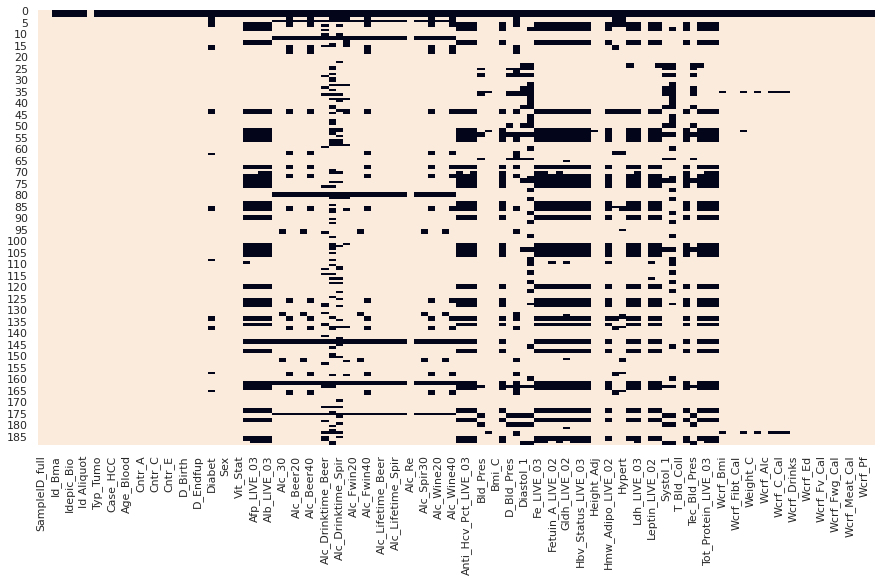

In [11]:
plt.figure(figsize=(15,8))
print(metadata2.shape)
sns.heatmap(metadata2.notna(), cbar=False);

## c - Keep only quantitative metadata and remove Blanks rows

In [12]:
metadata2_no_Blanks = metadata2[metadata2['CaseCtrl'] != 'Blank']
metadata2_no_Blanks_quanti = metadata2_no_Blanks[metadata2_no_Blanks.dtypes[metadata2_no_Blanks.dtypes == 'float64'].index]
metadata2_no_Blanks_quanti

,Match_Caseset,Age_Blood,Cntr_A,Cntr_B,Cntr_C,Cntr_D,Cntr_E,Country,Py,Adipo_LIVE_02,...,Wcrf_Ed,Wcrf_Fv,Wcrf_Fv_Cal,Wcrf_Fwg,Wcrf_Fwg_Cal,Wcrf_Meat,Wcrf_Meat_Cal,Wcrf_Pa,Wcrf_Pf,Wcrf_Pf_Cal
3,82.0,72.994,41.0,41.0,41.0,41.0,41.0,4.0,6.940,2.48,...,0.5,1.0,0.5,0.50,0.50,0.0,0.0,0.0,1.00,0.75
4,82.0,72.966,41.0,41.0,41.0,41.0,41.0,4.0,17.506,10.10,...,0.5,0.5,0.0,0.50,0.50,0.5,0.5,0.0,0.50,0.25
5,427.0,53.977,41.0,41.0,41.0,41.0,41.0,4.0,12.559,NaN,...,0.5,1.0,0.5,0.50,0.50,0.5,0.5,0.0,0.75,0.25
6,427.0,53.544,41.0,41.0,41.0,41.0,41.0,4.0,16.950,NaN,...,0.0,1.0,1.0,0.00,0.00,0.5,0.5,0.5,1.00,1.00
7,376.0,64.559,2.0,21.0,21.0,21.0,20.0,2.0,8.151,NaN,...,1.0,1.0,1.0,1.00,1.00,1.0,1.0,0.0,0.75,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,56.0,66.445,3.0,32.0,32.0,32.0,3.0,3.0,5.440,2.94,...,0.5,0.5,0.5,0.50,0.50,0.5,0.5,0.0,0.50,0.25
185,383.0,71.619,2.0,22.0,22.0,22.0,20.0,2.0,8.572,NaN,...,0.5,1.0,1.0,0.75,0.75,0.0,0.0,0.0,1.00,1.00
186,383.0,71.543,2.0,22.0,22.0,22.0,20.0,2.0,14.185,NaN,...,0.5,1.0,1.0,0.75,0.75,0.0,0.0,1.0,0.75,0.75
187,147.0,51.340,71.0,71.0,71.0,71.0,7.0,7.0,4.066,4.35,...,0.0,0.0,0.5,0.00,0.00,0.0,0.0,0.0,0.25,0.50


(186, 91)


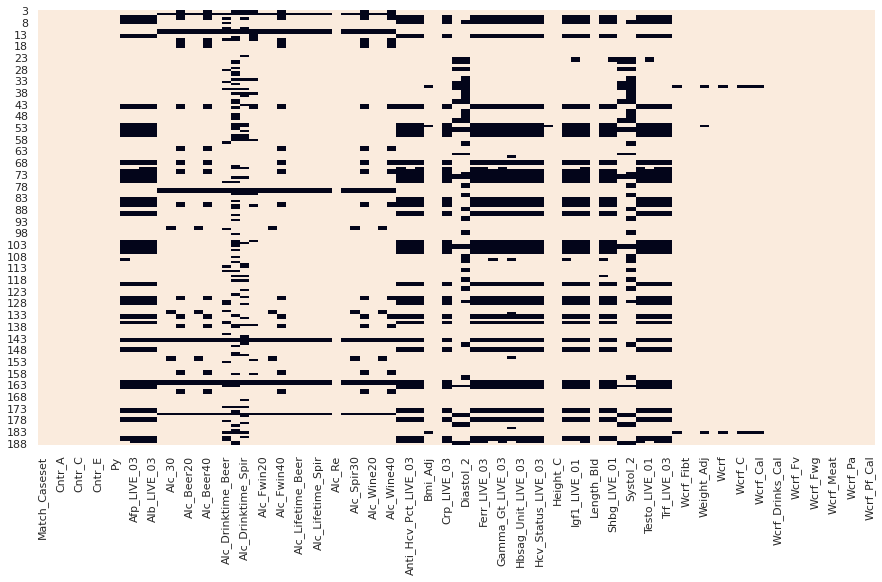

In [13]:
plt.figure(figsize=(15,8))
print(metadata2_no_Blanks_quanti.shape)
sns.heatmap(metadata2_no_Blanks_quanti.notna(), cbar=False);

## d - Check missing values in intensities

(189, 1215)


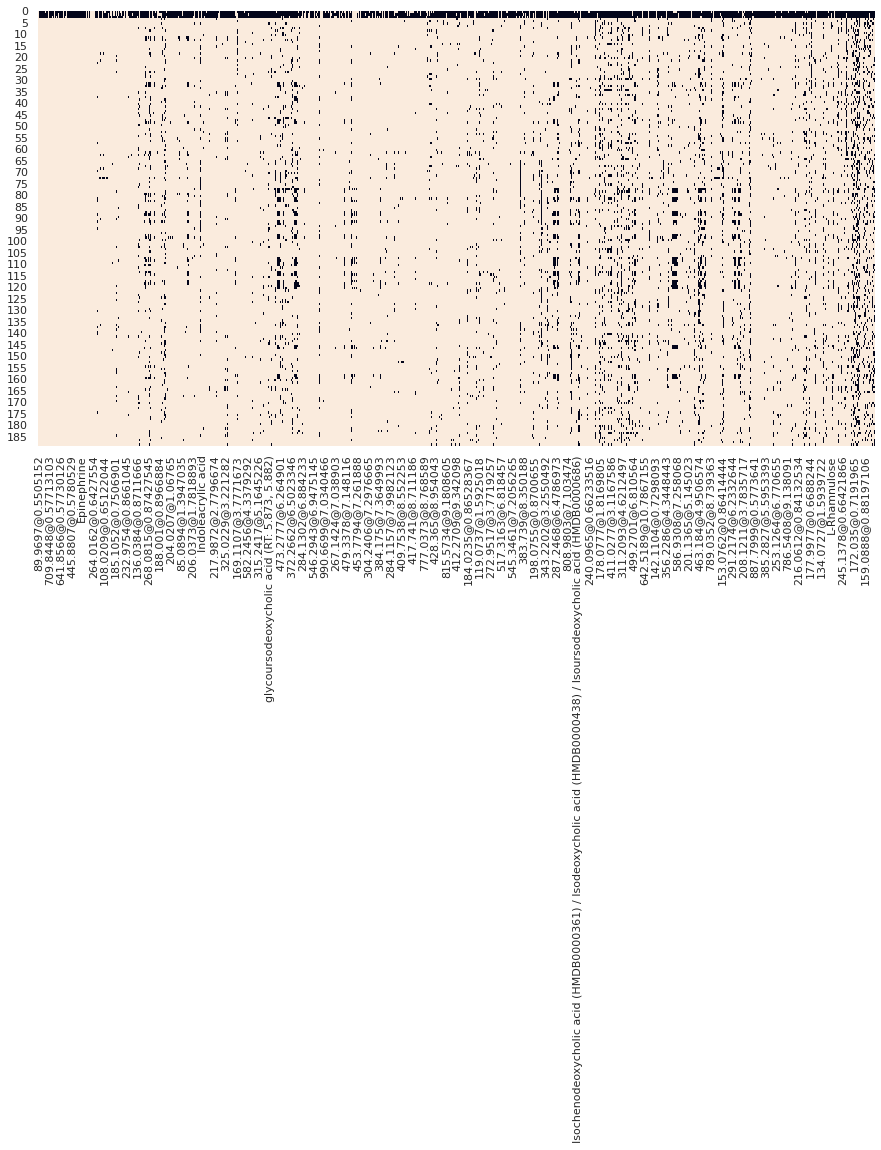

In [14]:
plt.figure(figsize=(15,8))
print(intensities.shape)
sns.heatmap(intensities.notna(), cbar=False);

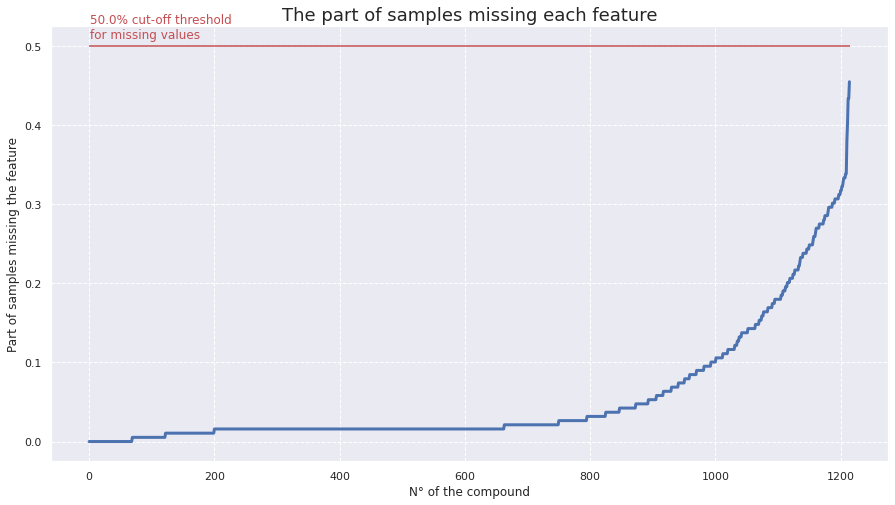

In [15]:
perc_mv = intensities.isna().sum() / intensities.shape[0]
threshold = 0.5
plt.figure(figsize=(15,8))
plt.plot(perc_mv.sort_values().values, color='b', linewidth=3)
plt.hlines(y=threshold, xmin=0, xmax=len(perc_mv), color ='r')
plt.text(x=2, y=threshold+0.01, s=f'{threshold*100}% cut-off threshold \nfor missing values', color='r', fontsize=12)
plt.xlabel('N° of the compound', fontsize=12)
plt.ylabel('Part of samples missing the feature', fontsize=12)
plt.title('The part of samples missing each feature', fontsize=18)
plt.grid(linestyle='--', linewidth=1)
plt.show()

# 2 - Impute missing values

## a - Impute intensities with 1's

In [16]:
from missing_value_imputation_functions import *

In [17]:
intensities_imp1 = const_imputer(intensities, 1)
intensities_imp1

,89.9697@0.5505152,90.973@0.55399996,939.813@0.56963736,157.9574@0.5643974,871.8258@0.5736113,803.8387@0.5745634,973.8083@0.56959826,599.8754@0.5742488,811.8258@0.57766384,667.8631@0.57489955,...,225.1218@0.86389714,398.7578@8.768545,288.1272@6.883725,126.0287@1.5353005,429.2873@6.211831,419.2505@8.916426,518.2205@6.2066946,400.2586@7.130359,103.0998@7.112515,267.142@6.969883
0,48008,418,1.0,16766,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,44590,223,1.0,14908,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1429.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,46261,333,1.0,14117,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1685.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,4195138,40495,42242.0,2794282,50841.0,60628.0,74517.0,100523.0,64318.0,108194.0,...,1.0,98959.0,20987.0,178906.0,1.0,184072.0,2547.0,6454.0,1.0,149023.0
4,4306680,38555,49922.0,2930790,61613.0,73916.0,84277.0,120525.0,69334.0,133694.0,...,2414.0,93145.0,28323.0,1.0,1.0,1.0,1043.0,6390.0,403011.0,164386.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,4416705,40954,47502.0,3017039,56174.0,69562.0,81828.0,93578.0,64371.0,122940.0,...,1.0,97137.0,24680.0,96880.0,1965.0,1.0,1781.0,40682.0,228548.0,111077.0
185,4727455,44619,65454.0,3237331,80203.0,99917.0,114212.0,127797.0,59777.0,169132.0,...,4823.0,1.0,17378.0,93893.0,9988.0,87218.0,9131.0,1.0,221296.0,97565.0
186,4643850,44234,62270.0,3170819,75882.0,94129.0,104118.0,120689.0,60576.0,159518.0,...,4761.0,1.0,16624.0,108831.0,3127.0,1.0,2387.0,17483.0,369559.0,1.0
187,4107050,38737,27127.0,2681910,30093.0,39345.0,52179.0,57230.0,56211.0,67452.0,...,38674.0,89525.0,11619.0,105422.0,3152.0,89313.0,2485.0,14052.0,212520.0,1.0


## b - Convert all intensities columns to integers

In [18]:
intensities_imp1.dtypes.value_counts()

float64    1153
int64        62
dtype: int64

In [19]:
intensities_imp1 = intensities_imp1.astype(int)
intensities_imp1

,89.9697@0.5505152,90.973@0.55399996,939.813@0.56963736,157.9574@0.5643974,871.8258@0.5736113,803.8387@0.5745634,973.8083@0.56959826,599.8754@0.5742488,811.8258@0.57766384,667.8631@0.57489955,...,225.1218@0.86389714,398.7578@8.768545,288.1272@6.883725,126.0287@1.5353005,429.2873@6.211831,419.2505@8.916426,518.2205@6.2066946,400.2586@7.130359,103.0998@7.112515,267.142@6.969883
0,48008,418,1,16766,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,44590,223,1,14908,1,1,1,1,1,1,...,1,1,1429,1,1,1,1,1,1,1
2,46261,333,1,14117,1,1,1,1,1,1,...,1,1,1685,1,1,1,1,1,1,1
3,4195138,40495,42242,2794282,50841,60628,74517,100523,64318,108194,...,1,98959,20987,178906,1,184072,2547,6454,1,149023
4,4306680,38555,49922,2930790,61613,73916,84277,120525,69334,133694,...,2414,93145,28323,1,1,1,1043,6390,403011,164386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,4416705,40954,47502,3017039,56174,69562,81828,93578,64371,122940,...,1,97137,24680,96880,1965,1,1781,40682,228548,111077
185,4727455,44619,65454,3237331,80203,99917,114212,127797,59777,169132,...,4823,1,17378,93893,9988,87218,9131,1,221296,97565
186,4643850,44234,62270,3170819,75882,94129,104118,120689,60576,159518,...,4761,1,16624,108831,3127,1,2387,17483,369559,1
187,4107050,38737,27127,2681910,30093,39345,52179,57230,56211,67452,...,38674,89525,11619,105422,3152,89313,2485,14052,212520,1


In [20]:
intensities_imp1.dtypes.value_counts()

int64    1215
dtype: int64

In [21]:
intensities_imp1_no_Blanks = intensities_imp1.iloc[3:,:]
intensities_imp1_no_Blanks

,89.9697@0.5505152,90.973@0.55399996,939.813@0.56963736,157.9574@0.5643974,871.8258@0.5736113,803.8387@0.5745634,973.8083@0.56959826,599.8754@0.5742488,811.8258@0.57766384,667.8631@0.57489955,...,225.1218@0.86389714,398.7578@8.768545,288.1272@6.883725,126.0287@1.5353005,429.2873@6.211831,419.2505@8.916426,518.2205@6.2066946,400.2586@7.130359,103.0998@7.112515,267.142@6.969883
3,4195138,40495,42242,2794282,50841,60628,74517,100523,64318,108194,...,1,98959,20987,178906,1,184072,2547,6454,1,149023
4,4306680,38555,49922,2930790,61613,73916,84277,120525,69334,133694,...,2414,93145,28323,1,1,1,1043,6390,403011,164386
5,4457872,41892,49890,2974132,61331,73473,86310,116998,69140,132044,...,1,93997,16393,171962,1,125149,1,9443,1,99967
6,4128863,39711,33517,2769811,40177,46566,60449,80091,62495,87292,...,1378,93555,1,1,4293,140514,4280,5900,399109,164202
7,4438077,43225,62259,2976035,74326,93735,102111,138763,59839,163759,...,1,96460,1,158917,9750,154104,12004,1,264003,105903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,4416705,40954,47502,3017039,56174,69562,81828,93578,64371,122940,...,1,97137,24680,96880,1965,1,1781,40682,228548,111077
185,4727455,44619,65454,3237331,80203,99917,114212,127797,59777,169132,...,4823,1,17378,93893,9988,87218,9131,1,221296,97565
186,4643850,44234,62270,3170819,75882,94129,104118,120689,60576,159518,...,4761,1,16624,108831,3127,1,2387,17483,369559,1
187,4107050,38737,27127,2681910,30093,39345,52179,57230,56211,67452,...,38674,89525,11619,105422,3152,89313,2485,14052,212520,1


## c - Impute quantitative metadata with half min value of column

In [22]:
metadata2_no_Blanks_quanti_imp_halfmin = half_min_imputer(metadata2_no_Blanks_quanti)
metadata2_no_Blanks_quanti_imp_halfmin

,Match_Caseset,Age_Blood,Cntr_A,Cntr_B,Cntr_C,Cntr_D,Cntr_E,Country,Py,Adipo_LIVE_02,...,Wcrf_Ed,Wcrf_Fv,Wcrf_Fv_Cal,Wcrf_Fwg,Wcrf_Fwg_Cal,Wcrf_Meat,Wcrf_Meat_Cal,Wcrf_Pa,Wcrf_Pf,Wcrf_Pf_Cal
3,82.0,72.994,41.0,41.0,41.0,41.0,41.0,4.0,6.940,2.48,...,0.5,1.0,0.5,0.50,0.50,0.0,0.0,0.0,1.00,0.75
4,82.0,72.966,41.0,41.0,41.0,41.0,41.0,4.0,17.506,10.10,...,0.5,0.5,0.0,0.50,0.50,0.5,0.5,0.0,0.50,0.25
5,427.0,53.977,41.0,41.0,41.0,41.0,41.0,4.0,12.559,0.71,...,0.5,1.0,0.5,0.50,0.50,0.5,0.5,0.0,0.75,0.25
6,427.0,53.544,41.0,41.0,41.0,41.0,41.0,4.0,16.950,0.71,...,0.0,1.0,1.0,0.00,0.00,0.5,0.5,0.5,1.00,1.00
7,376.0,64.559,2.0,21.0,21.0,21.0,20.0,2.0,8.151,0.71,...,1.0,1.0,1.0,1.00,1.00,1.0,1.0,0.0,0.75,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,56.0,66.445,3.0,32.0,32.0,32.0,3.0,3.0,5.440,2.94,...,0.5,0.5,0.5,0.50,0.50,0.5,0.5,0.0,0.50,0.25
185,383.0,71.619,2.0,22.0,22.0,22.0,20.0,2.0,8.572,0.71,...,0.5,1.0,1.0,0.75,0.75,0.0,0.0,0.0,1.00,1.00
186,383.0,71.543,2.0,22.0,22.0,22.0,20.0,2.0,14.185,0.71,...,0.5,1.0,1.0,0.75,0.75,0.0,0.0,1.0,0.75,0.75
187,147.0,51.340,71.0,71.0,71.0,71.0,7.0,7.0,4.066,4.35,...,0.0,0.0,0.5,0.00,0.00,0.0,0.0,0.0,0.25,0.50


# 3 - Concat preprocessed metadata (*metadata2_no_Blanks_quanti_imp_halfmin*) and preprocessed intensities (*intensities_imp1*)

In [23]:
peakTable_Agilent_imp = pd.concat([metadata2_no_Blanks_quanti_imp_halfmin, intensities_imp1_no_Blanks], axis=1)
peakTable_Agilent_imp

,Match_Caseset,Age_Blood,Cntr_A,Cntr_B,Cntr_C,Cntr_D,Cntr_E,Country,Py,Adipo_LIVE_02,...,225.1218@0.86389714,398.7578@8.768545,288.1272@6.883725,126.0287@1.5353005,429.2873@6.211831,419.2505@8.916426,518.2205@6.2066946,400.2586@7.130359,103.0998@7.112515,267.142@6.969883
3,82.0,72.994,41.0,41.0,41.0,41.0,41.0,4.0,6.940,2.48,...,1,98959,20987,178906,1,184072,2547,6454,1,149023
4,82.0,72.966,41.0,41.0,41.0,41.0,41.0,4.0,17.506,10.10,...,2414,93145,28323,1,1,1,1043,6390,403011,164386
5,427.0,53.977,41.0,41.0,41.0,41.0,41.0,4.0,12.559,0.71,...,1,93997,16393,171962,1,125149,1,9443,1,99967
6,427.0,53.544,41.0,41.0,41.0,41.0,41.0,4.0,16.950,0.71,...,1378,93555,1,1,4293,140514,4280,5900,399109,164202
7,376.0,64.559,2.0,21.0,21.0,21.0,20.0,2.0,8.151,0.71,...,1,96460,1,158917,9750,154104,12004,1,264003,105903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,56.0,66.445,3.0,32.0,32.0,32.0,3.0,3.0,5.440,2.94,...,1,97137,24680,96880,1965,1,1781,40682,228548,111077
185,383.0,71.619,2.0,22.0,22.0,22.0,20.0,2.0,8.572,0.71,...,4823,1,17378,93893,9988,87218,9131,1,221296,97565
186,383.0,71.543,2.0,22.0,22.0,22.0,20.0,2.0,14.185,0.71,...,4761,1,16624,108831,3127,1,2387,17483,369559,1
187,147.0,51.340,71.0,71.0,71.0,71.0,7.0,7.0,4.066,4.35,...,38674,89525,11619,105422,3152,89313,2485,14052,212520,1


# 4 - Standard scale imputed peak table (metadata + intensities)

In [24]:
from normalisation_scaling_functions import *

In [25]:
peakTable_Agilent_imp_std = normPeakTable(peakTable_Agilent_imp, 'autoscaling', based='metabolites')
peakTable_Agilent_imp_std

,Match_Caseset,Age_Blood,Cntr_A,Cntr_B,Cntr_C,Cntr_D,Cntr_E,Country,Py,Adipo_LIVE_02,...,225.1218@0.86389714,398.7578@8.768545,288.1272@6.883725,126.0287@1.5353005,429.2873@6.211831,419.2505@8.916426,518.2205@6.2066946,400.2586@7.130359,103.0998@7.112515,267.142@6.969883
0,-0.917504,1.870434,0.311481,-0.433431,-0.436959,-0.435206,2.106210,-0.394358,-0.621876,-0.453535,...,-0.499998,0.556855,0.449726,1.248818,-0.354149,2.289167,-0.306289,-0.151820,-1.507915,0.464131
1,-0.917504,1.866567,0.311481,-0.433431,-0.436959,-0.435206,2.106210,-0.394358,1.447642,1.561966,...,-0.400619,0.376691,1.146810,-1.480012,-0.354149,-2.463808,-0.372643,-0.156620,1.430052,0.628509
2,1.146590,-0.755844,0.311481,-0.433431,-0.436959,-0.435206,2.106210,-0.394358,0.478694,-0.921702,...,-0.499998,0.403093,0.013193,1.142901,-0.354149,0.767691,-0.418614,0.072333,-1.507915,-0.060749
3,1.146590,-0.815642,0.311481,-0.433431,-0.436959,-0.435206,2.106210,-0.394358,1.338740,-0.921702,...,-0.443286,0.389396,-1.544414,-1.480012,-0.223263,1.164437,-0.229832,-0.193366,1.401606,0.626540
4,0.841463,0.705547,-0.985581,-1.232817,-1.237297,-1.235091,0.386909,-1.183075,-0.384682,-0.921702,...,-0.499998,0.479416,-1.544414,0.943927,-0.056850,1.515350,0.110938,-0.635748,0.416675,0.002764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,-1.073058,0.966007,-0.952323,-0.793155,-0.797111,-0.795155,-1.004906,-0.788716,-0.915675,-0.331864,...,-0.499998,0.500395,0.800643,-0.002321,-0.294256,-2.463808,-0.340083,2.415032,0.158206,0.058124
182,0.883343,1.680544,-0.985581,-1.192848,-1.197280,-1.195097,0.386909,-1.183075,-0.302223,-0.921702,...,-0.301404,-2.509648,0.106790,-0.047881,-0.049592,-0.211741,-0.015814,-0.635748,0.105339,-0.086449
183,0.883343,1.670049,-0.985581,-1.192848,-1.197280,-1.195097,0.386909,-1.183075,0.797172,-0.921702,...,-0.303957,-2.509648,0.035143,0.179967,-0.258820,-2.463808,-0.313348,0.675275,1.186185,-1.130345
184,-0.528616,-1.120018,1.309221,0.765649,0.763548,0.764621,-0.677421,0.788716,-1.184794,0.041083,...,1.092750,0.264515,-0.440444,0.127970,-0.258058,-0.157645,-0.309024,0.417975,0.041361,-1.130345


# 5 - Dimensionality reduction

In [26]:
from dimensionality_reduction_functions import *

In [27]:
targets = ['CaseCtrl', 'Typ_Tumo']

## a - PCA then t-SNE

#################################################################################################### 



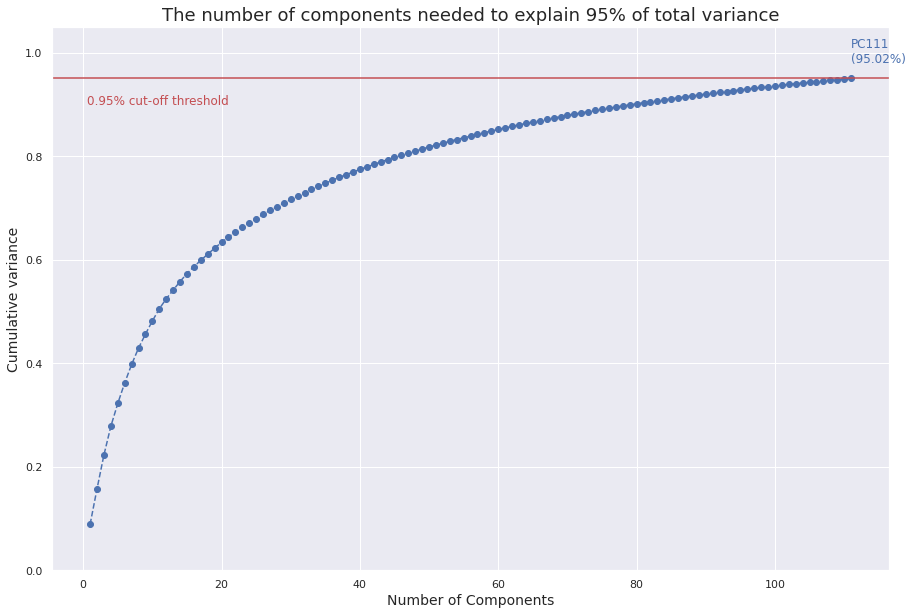

Initial number of dimension : 1306
Final number of dimension : 111


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC102,PC103,PC104,PC105,PC106,PC107,PC108,PC109,PC110,PC111
0,24.632104,5.793642,4.516306,0.360038,10.954064,-5.781001,-0.249022,1.425555,1.948914,-0.844017,...,0.336760,-0.596261,-0.747724,2.291608,1.646189,-0.412162,-0.340027,-0.048112,0.654355,2.066784
1,25.918645,-2.969194,3.678361,-1.274112,-2.130554,-5.445601,8.285131,-6.315341,-3.814448,-7.087666,...,2.128861,-0.099680,1.077020,1.022961,2.367127,-1.910068,2.479007,1.332697,-0.900250,0.414686
2,8.590309,5.982145,-6.853186,-13.788358,9.256095,-7.182674,-2.850959,-9.707536,-7.870334,-2.223396,...,-2.372010,-1.188742,-1.745793,-0.004564,2.183151,3.985639,-0.152995,-0.474814,-1.207154,0.004208
3,24.095692,11.659753,-0.218109,-0.338098,-5.336966,-13.576418,4.101305,0.165217,1.341769,1.308105,...,0.279354,0.722413,2.243884,-0.538704,1.148439,0.764746,-0.125859,0.063554,2.008700,-3.649772
4,-9.286653,2.182570,1.371646,-11.060453,5.620401,-8.301159,8.197266,-8.063572,0.856105,1.444484,...,-2.988222,-0.751366,-1.508187,-1.847816,-1.437414,-3.530900,0.828811,-1.192942,4.528131,-1.062973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,7.320065,2.734487,-2.612213,1.283922,-4.798617,-1.966452,-12.569718,7.318394,-5.107412,10.673793,...,-1.388710,-0.464988,-2.047852,1.167103,-1.123609,0.213419,0.775953,1.676924,0.687245,1.193257
182,-8.817506,6.822866,-6.793595,-8.171247,2.332520,7.440930,-5.037504,6.644852,1.715671,0.281416,...,0.736017,-1.721335,-1.437616,-0.056196,-0.933198,0.268806,-0.317514,-1.187084,-3.928734,0.324689
183,-8.170980,-1.628310,-9.850299,-5.959815,-3.607011,1.494435,-6.603571,1.863288,4.746651,0.719755,...,1.925377,0.350114,0.240693,-0.925811,1.615520,0.574978,1.163190,-0.584988,-1.313599,0.459651
184,8.450974,18.316726,-5.572107,8.708667,-10.757371,-3.135720,-14.006717,-3.117304,4.653278,6.765672,...,-0.758981,0.268508,-0.312673,1.221690,0.800450,-0.716039,1.913429,2.018858,-0.690538,0.235499



 #################################################################################################### 

Time to compute t-SNE (input dataframe of shape (186, 111)) : 0.47 seconds

----------------------------------------------------------------------------------------------------


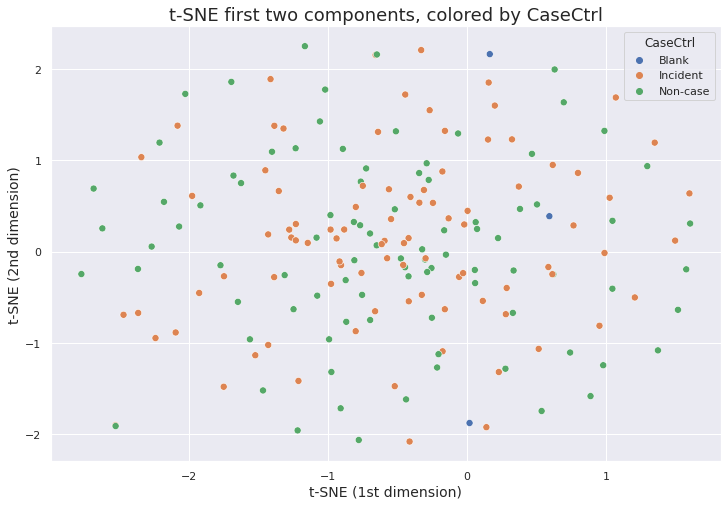

----------------------------------------------------------------------------------------------------


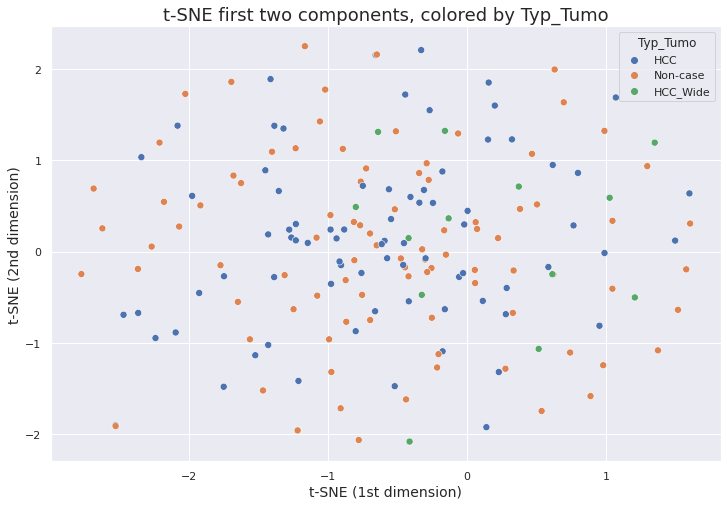

----------------------------------------------------------------------------------------------------


,tSNE1,tSNE2
0,0.019169,-1.876796
1,0.164703,2.162551
2,0.593669,0.387699
3,-0.800371,-0.871523
4,1.578724,-0.194307
...,...,...
181,-0.868047,-0.768754
182,-0.749086,0.720421
183,-0.799581,0.488795
184,-1.648039,-0.550380


In [37]:
print(100 * '#', '\n')

X_PCA, explained_variance = perform_PCA(peakTable_Agilent_imp_std, part_explained_variance=0.95)
print(f'Initial number of dimension : {peakTable_Agilent_imp_std.shape[1]}')
print(f'Final number of dimension : {explained_variance.shape[0]}')
display(X_PCA)

print('\n', 100 * '#', '\n')

n_components = 2
peakTable_Agilent_imp_std_PCA_tSNE = perform_tSNE(X_PCA, metadata, n_components=n_components, targets_plot=targets)
display(peakTable_Agilent_imp_std_PCA_tSNE)

# 6 - Clustering

In [38]:
from clustering_functions import *

## a - Kmeans

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


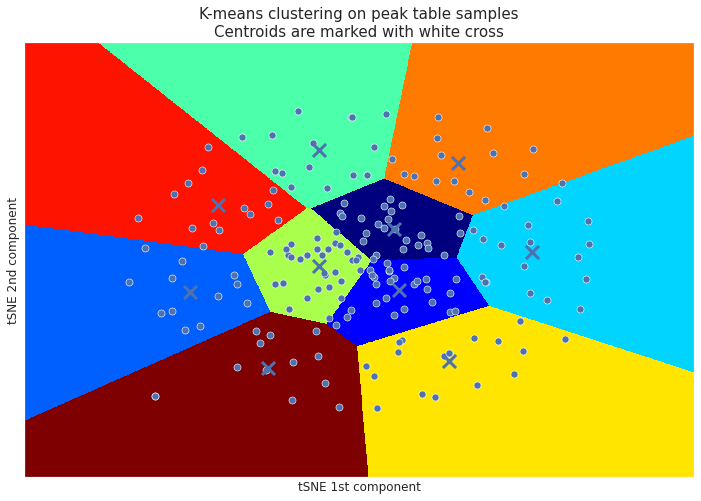

Inertia of k-means model : 48.68


In [39]:
kmeans = perform_kmeans(peakTable_Agilent_imp_std_PCA_tSNE.astype('double'), n_clusters=10, col_prefix='tSNE')

## b - Affinity propagation

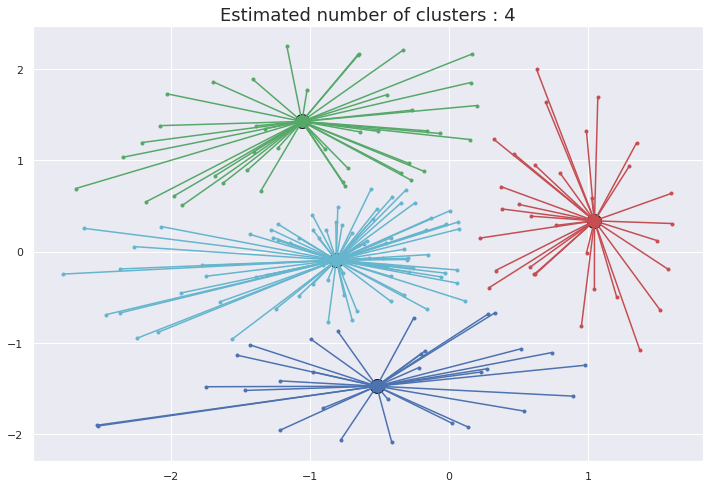

In [40]:
af = perform_affinity_propagation(peakTable_Agilent_imp_std_PCA_tSNE)

In [42]:
pd.concat([peakTable_Agilent[['Match_Caseset', 'CaseCtrl', 'Typ_Tumo']], pd.DataFrame(af.labels_, columns=['af'])], axis=1)

,Match_Caseset,CaseCtrl,Typ_Tumo,af
0,NaN,NaN,NaN,0.0
1,NaN,NaN,NaN,1.0
2,NaN,NaN,NaN,2.0
3,82.0,Incident,HCC/,0.0
4,82.0,Non-case,NaN,2.0
...,...,...,...,...
184,56.0,Non-case,NaN,3.0
185,383.0,Incident,HCC/,3.0
186,383.0,Non-case,NaN,NaN
187,147.0,Incident,HCC/,NaN


## c - Hierarchical clustering

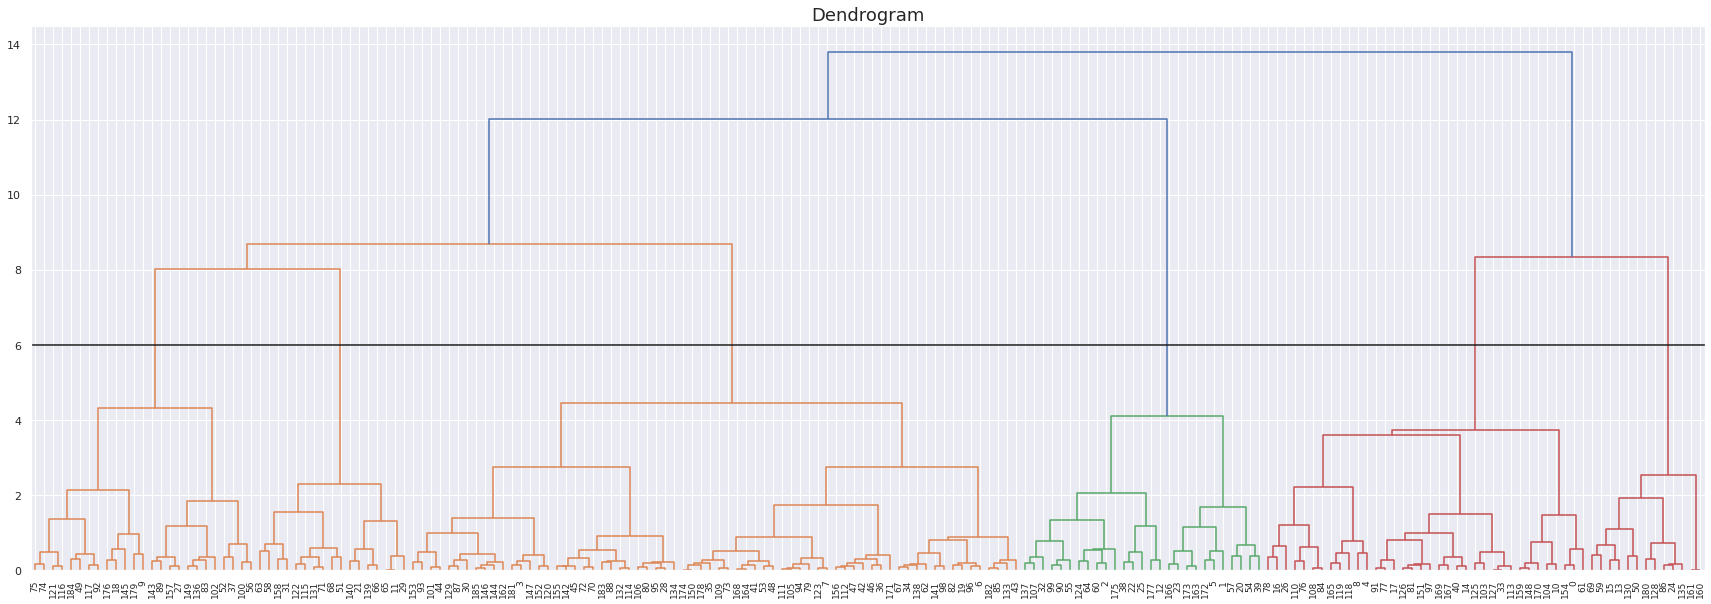

In [43]:
plot_dendrogram(peakTable_Agilent_imp_std_PCA_tSNE, hline=6)

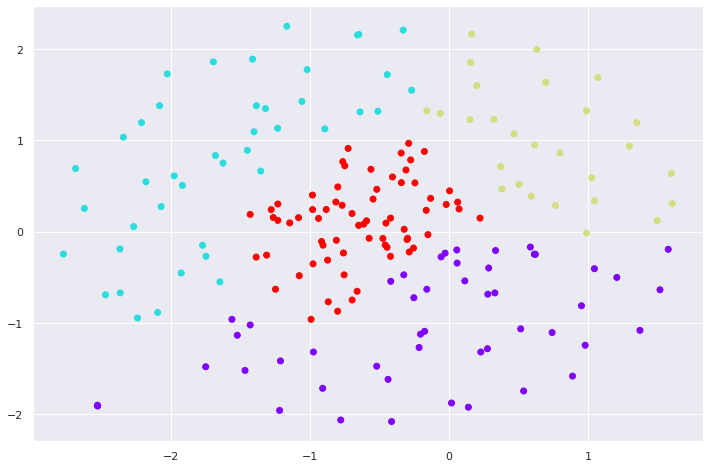

In [44]:
hc = perform_hierarchical_clustering(peakTable_Agilent_imp_std_PCA_tSNE, n_clusters=4)

In [54]:
results = pd.concat([pd.DataFrame(hc.labels_, columns=['hc_labels']), peakTable_Agilent_imp_std], axis=1)
results

,hc_labels,Match_Caseset,Age_Blood,Cntr_A,Cntr_B,Cntr_C,Cntr_D,Cntr_E,Country,Py,...,225.1218@0.86389714,398.7578@8.768545,288.1272@6.883725,126.0287@1.5353005,429.2873@6.211831,419.2505@8.916426,518.2205@6.2066946,400.2586@7.130359,103.0998@7.112515,267.142@6.969883
0,0,-0.917504,1.870434,0.311481,-0.433431,-0.436959,-0.435206,2.106210,-0.394358,-0.621876,...,-0.499998,0.556855,0.449726,1.248818,-0.354149,2.289167,-0.306289,-0.151820,-1.507915,0.464131
1,2,-0.917504,1.866567,0.311481,-0.433431,-0.436959,-0.435206,2.106210,-0.394358,1.447642,...,-0.400619,0.376691,1.146810,-1.480012,-0.354149,-2.463808,-0.372643,-0.156620,1.430052,0.628509
2,2,1.146590,-0.755844,0.311481,-0.433431,-0.436959,-0.435206,2.106210,-0.394358,0.478694,...,-0.499998,0.403093,0.013193,1.142901,-0.354149,0.767691,-0.418614,0.072333,-1.507915,-0.060749
3,3,1.146590,-0.815642,0.311481,-0.433431,-0.436959,-0.435206,2.106210,-0.394358,1.338740,...,-0.443286,0.389396,-1.544414,-1.480012,-0.223263,1.164437,-0.229832,-0.193366,1.401606,0.626540
4,0,0.841463,0.705547,-0.985581,-1.232817,-1.237297,-1.235091,0.386909,-1.183075,-0.384682,...,-0.499998,0.479416,-1.544414,0.943927,-0.056850,1.515350,0.110938,-0.635748,0.416675,0.002764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,3,-1.073058,0.966007,-0.952323,-0.793155,-0.797111,-0.795155,-1.004906,-0.788716,-0.915675,...,-0.499998,0.500395,0.800643,-0.002321,-0.294256,-2.463808,-0.340083,2.415032,0.158206,0.058124
182,3,0.883343,1.680544,-0.985581,-1.192848,-1.197280,-1.195097,0.386909,-1.183075,-0.302223,...,-0.301404,-2.509648,0.106790,-0.047881,-0.049592,-0.211741,-0.015814,-0.635748,0.105339,-0.086449
183,3,0.883343,1.670049,-0.985581,-1.192848,-1.197280,-1.195097,0.386909,-1.183075,0.797172,...,-0.303957,-2.509648,0.035143,0.179967,-0.258820,-2.463808,-0.313348,0.675275,1.186185,-1.130345
184,1,-0.528616,-1.120018,1.309221,0.765649,0.763548,0.764621,-0.677421,0.788716,-1.184794,...,1.092750,0.264515,-0.440444,0.127970,-0.258058,-0.157645,-0.309024,0.417975,0.041361,-1.130345


In [58]:
results.corr(method='pearson')

,hc_labels,Match_Caseset,Age_Blood,Cntr_A,Cntr_B,Cntr_C,Cntr_D,Cntr_E,Country,Py,...,225.1218@0.86389714,398.7578@8.768545,288.1272@6.883725,126.0287@1.5353005,429.2873@6.211831,419.2505@8.916426,518.2205@6.2066946,400.2586@7.130359,103.0998@7.112515,267.142@6.969883
hc_labels,1.000000,0.103339,0.024677,0.050254,0.195900,0.193920,0.194916,-0.116000,0.195925,0.205493,...,-0.163182,-0.069299,-0.075042,-0.075142,-0.236741,-0.112780,-0.251702,-0.017133,0.131838,0.036770
Match_Caseset,0.103339,1.000000,-0.105948,0.281418,0.419076,0.419684,0.419392,-0.113227,0.421470,0.184028,...,0.144045,0.106816,0.088027,0.092492,-0.030728,0.015521,-0.031873,-0.138809,-0.132983,0.031412
Age_Blood,0.024677,-0.105948,1.000000,0.074122,-0.072493,-0.073495,-0.072996,0.057886,-0.062647,-0.020857,...,-0.036942,-0.050260,0.085004,-0.024621,-0.002278,0.060924,-0.006865,0.058419,0.150410,0.039231
Cntr_A,0.050254,0.281418,0.074122,1.000000,0.515421,0.517073,0.516261,-0.165881,0.525046,-0.077041,...,-0.005600,0.185769,0.223926,0.155981,0.064833,0.125074,0.076114,-0.167594,0.016690,-0.059872
Cntr_B,0.195900,0.419076,-0.072493,0.515421,1.000000,0.999885,0.999971,-0.465765,0.999207,-0.053764,...,0.288301,0.187036,0.081069,0.173704,0.138961,0.026457,0.160763,-0.107186,-0.103271,0.056939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419.2505@8.916426,-0.112780,0.015521,0.060924,0.125074,0.026457,0.026562,0.026510,0.026922,0.031384,-0.114417,...,-0.160278,0.159258,-0.020935,0.070141,0.157464,1.000000,0.183375,-0.004155,-0.084875,0.121392
518.2205@6.2066946,-0.251702,-0.031873,-0.006865,0.076114,0.160763,0.160500,0.160636,-0.171608,0.162241,-0.369480,...,0.238239,0.080548,-0.042340,0.015361,0.982662,0.183375,1.000000,-0.060268,-0.127336,-0.145304
400.2586@7.130359,-0.017133,-0.138809,0.058419,-0.167594,-0.107186,-0.108323,-0.107757,0.002727,-0.105112,0.027502,...,-0.014388,-0.089347,0.019823,-0.078575,-0.051476,-0.004155,-0.060268,1.000000,0.043232,-0.022227
103.0998@7.112515,0.131838,-0.132983,0.150410,0.016690,-0.103271,-0.103611,-0.103444,0.023610,-0.100626,0.098419,...,-0.174293,0.005254,0.035011,-0.041044,-0.135763,-0.084875,-0.127336,0.043232,1.000000,0.027448


In [64]:
corr_sorted = results.corr(method='pearson')['hc_labels'].abs().sort_values()
corr_sorted

388.0869@0.65008324                                                  0.000047
398.2486@8.142346                                                    0.000093
445.7929@7.2652783                                                   0.000588
527.8152@7.08824                                                     0.000751
162.97@0.62873966                                                    0.000772
                                                                       ...   
135.068@1.2793788                                                    0.324304
m-Coumaric acid (HMDB0001713) / Enol-phenylpyruvate (HMDB0012225)    0.333340
114.0427@0.8568334                                                   0.339320
146.0367@0.8725177                                                   0.344837
hc_labels                                                            1.000000
Name: hc_labels, Length: 1307, dtype: float64

In [74]:
corr_sorted[corr_sorted > 0.2][:-1]

226.097@3.631355                                                     0.200603
Sphingosine                                                          0.200683
249.2077@6.9046288                                                   0.201569
301.2079@5.715016                                                    0.202452
227.2259@6.903871                                                    0.202804
                                                                       ...   
135.068@1.2793788                                                    0.324304
m-Coumaric acid (HMDB0001713) / Enol-phenylpyruvate (HMDB0012225)    0.333340
114.0427@0.8568334                                                   0.339320
146.0367@0.8725177                                                   0.344837
hc_labels                                                            1.000000
Name: hc_labels, Length: 165, dtype: float64

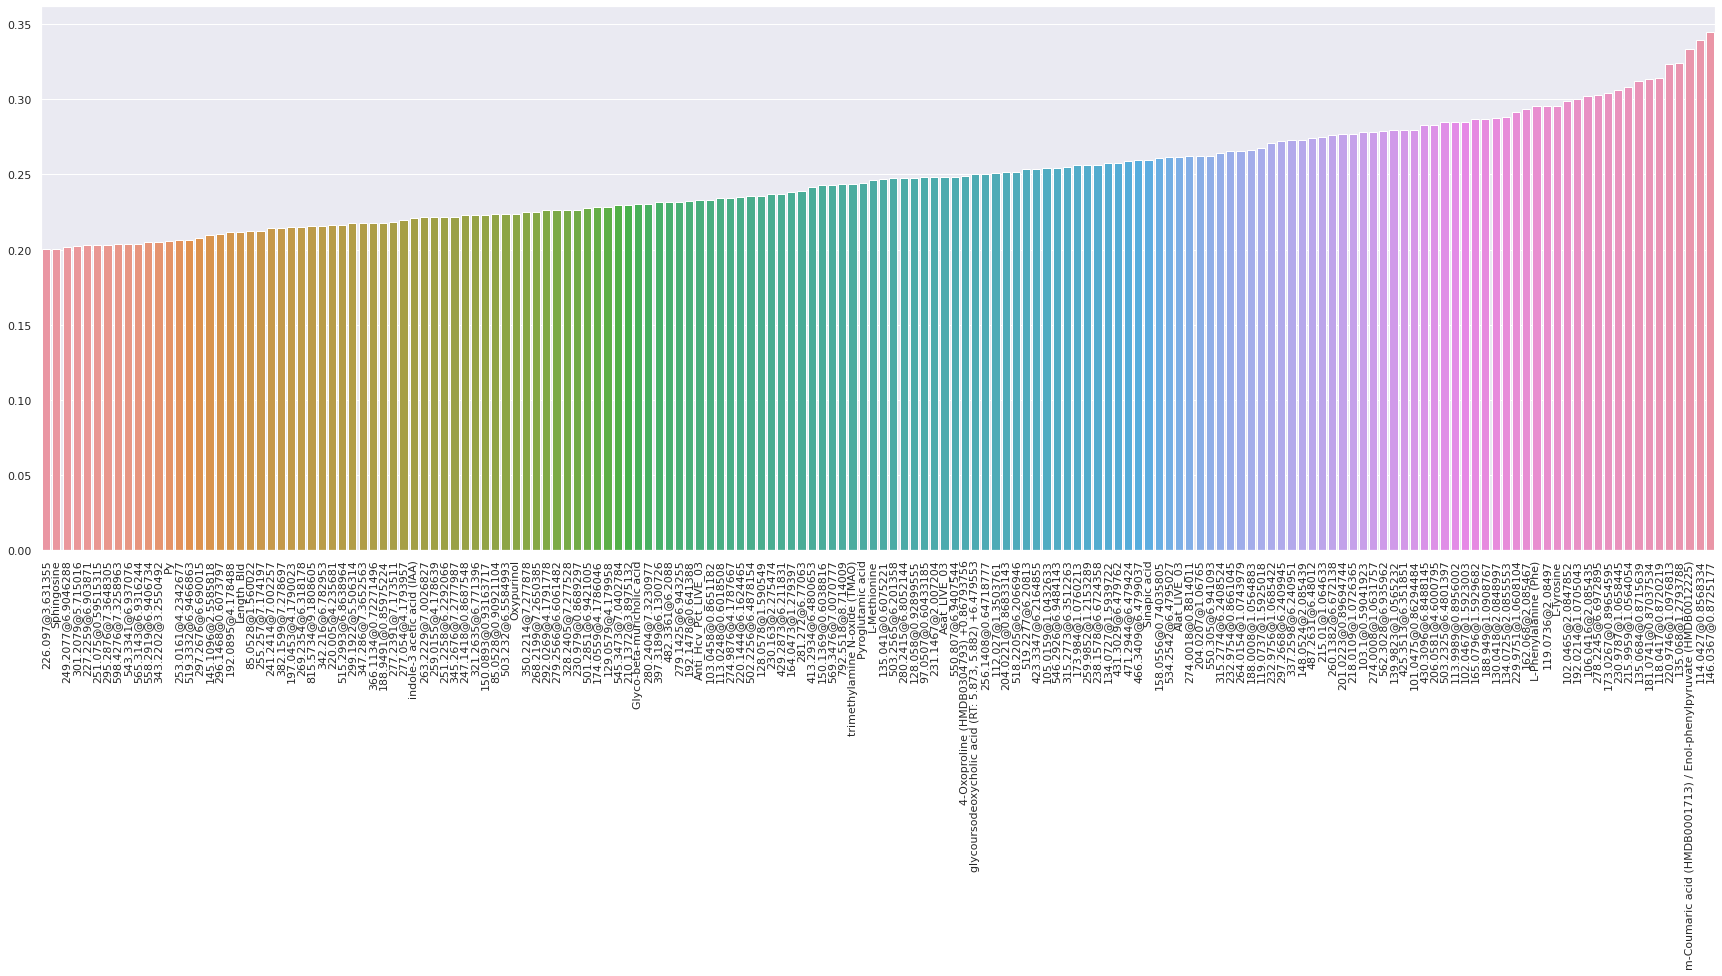

In [75]:
plt.figure(figsize=(30,10))
ax = sns.barplot(x=corr_sorted[corr_sorted > 0.2][:-1].index, y=corr_sorted[corr_sorted > 0.2][:-1].values)
plt.xticks(rotation=90);

In [52]:
pd.concat([peakTable_Agilent_imp_std, pd.DataFrame(hc.labels_, columns=['hc_labels'])], axis=1).corr()['hc_labels']

Match_Caseset         0.103339
Age_Blood             0.024677
Cntr_A                0.050254
Cntr_B                0.195900
Cntr_C                0.193920
                        ...   
518.2205@6.2066946   -0.251702
400.2586@7.130359    -0.017133
103.0998@7.112515     0.131838
267.142@6.969883      0.036770
hc_labels             1.000000
Name: hc_labels, Length: 1307, dtype: float64